In [ ]:
!pip install causal-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.1/192.1 kB 3.2 MB/s eta 0:00:00


  0%|          | 0/11 [00:00<?, ?it/s]


Causal Graph for Arctic Climate Variables:


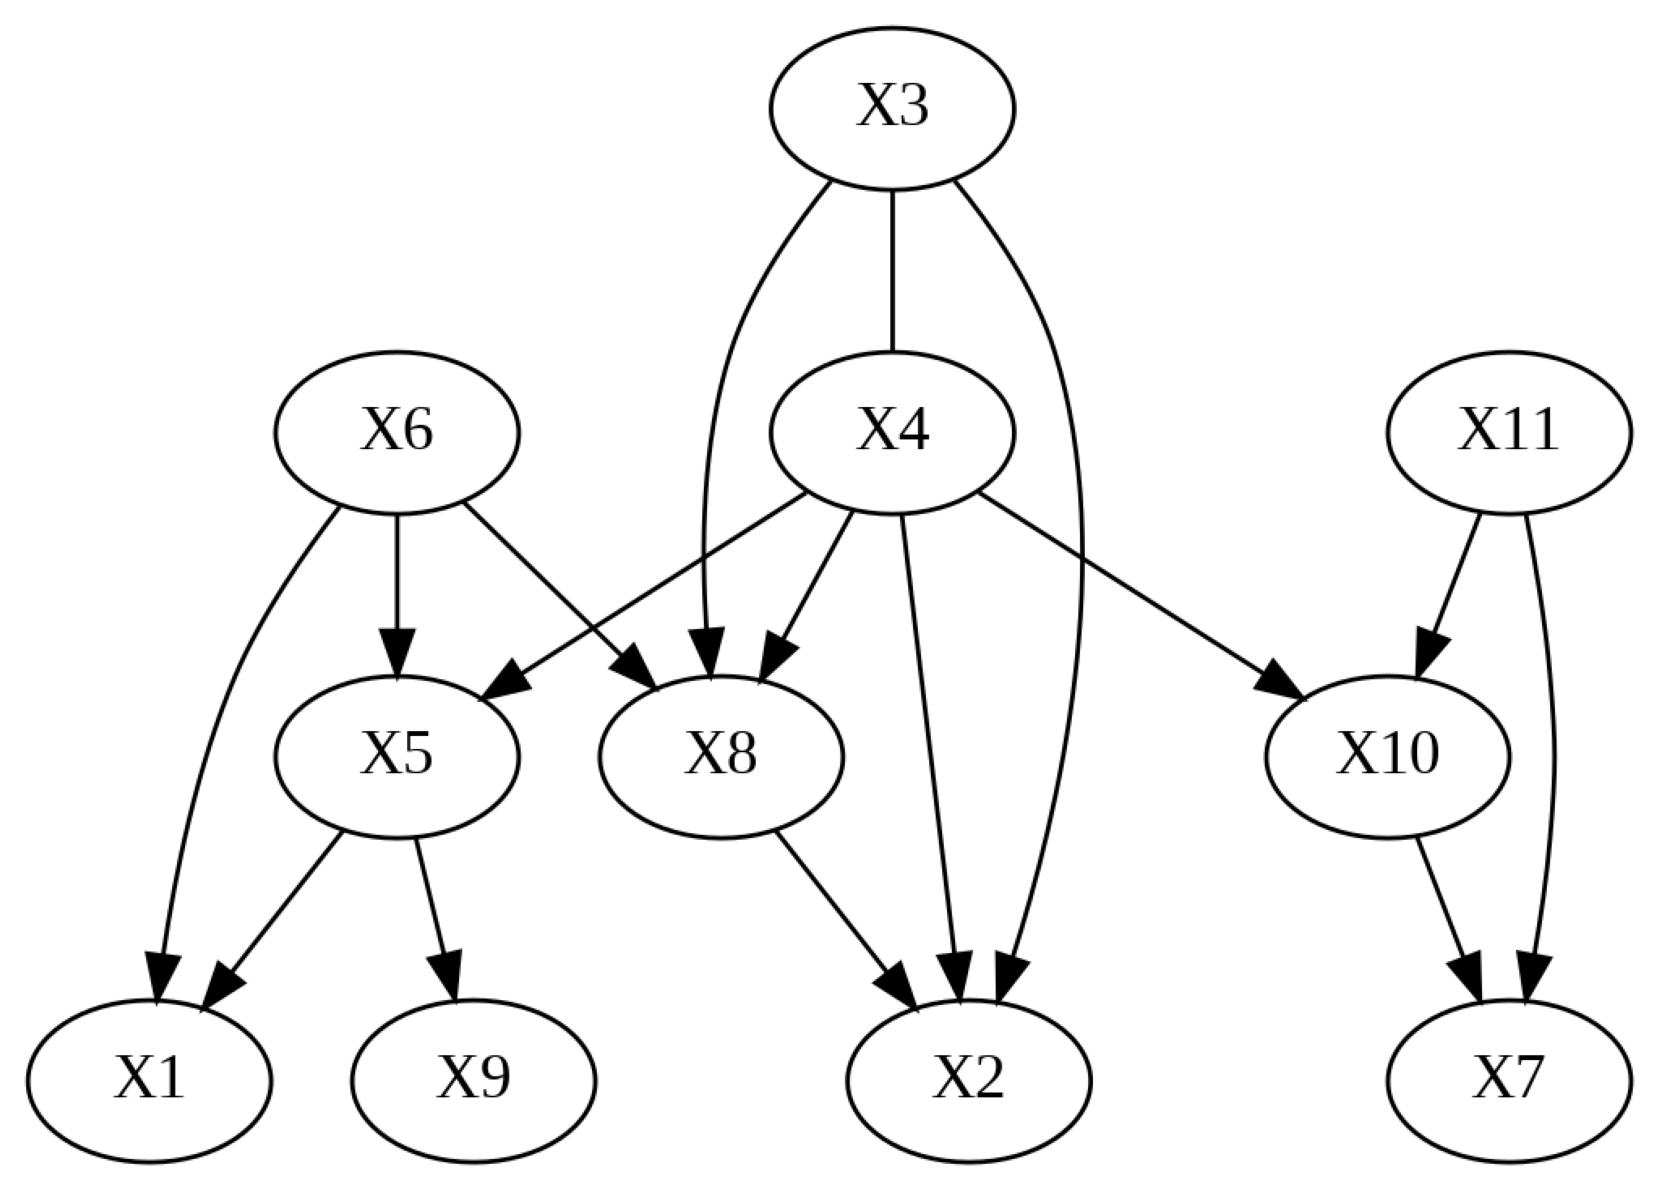


Summary Statistics:
         wind_10m  specific_humidity     LW_down     SW_down    rainfall  \
count  512.000000         512.000000  512.000000  512.000000  512.000000   
mean     5.161659           2.347192  242.631847   96.648066    1.386473   
std      0.442418           1.479176   44.160644   88.633618    0.332424   
min      4.249461           0.688896  174.794571    1.081732    0.794136   
25%      4.731577           1.030928  198.738697   17.190780    1.101611   
50%      5.238941           1.736932  236.223251   69.467151    1.350808   
75%      5.516891           3.701247  287.396752  191.557168    1.671406   
max      6.084062           5.497873  316.864409  252.105756    2.129987   

         snowfall         sst         t2m  surface_pressure  sea_ice_extent  
count  512.000000  512.000000  512.000000        512.000000    5.120000e+02  
mean     0.716998  274.774471  264.936639        981.169161    1.163456e+07  
std      0.291369    1.626384   10.644933          3.121954 

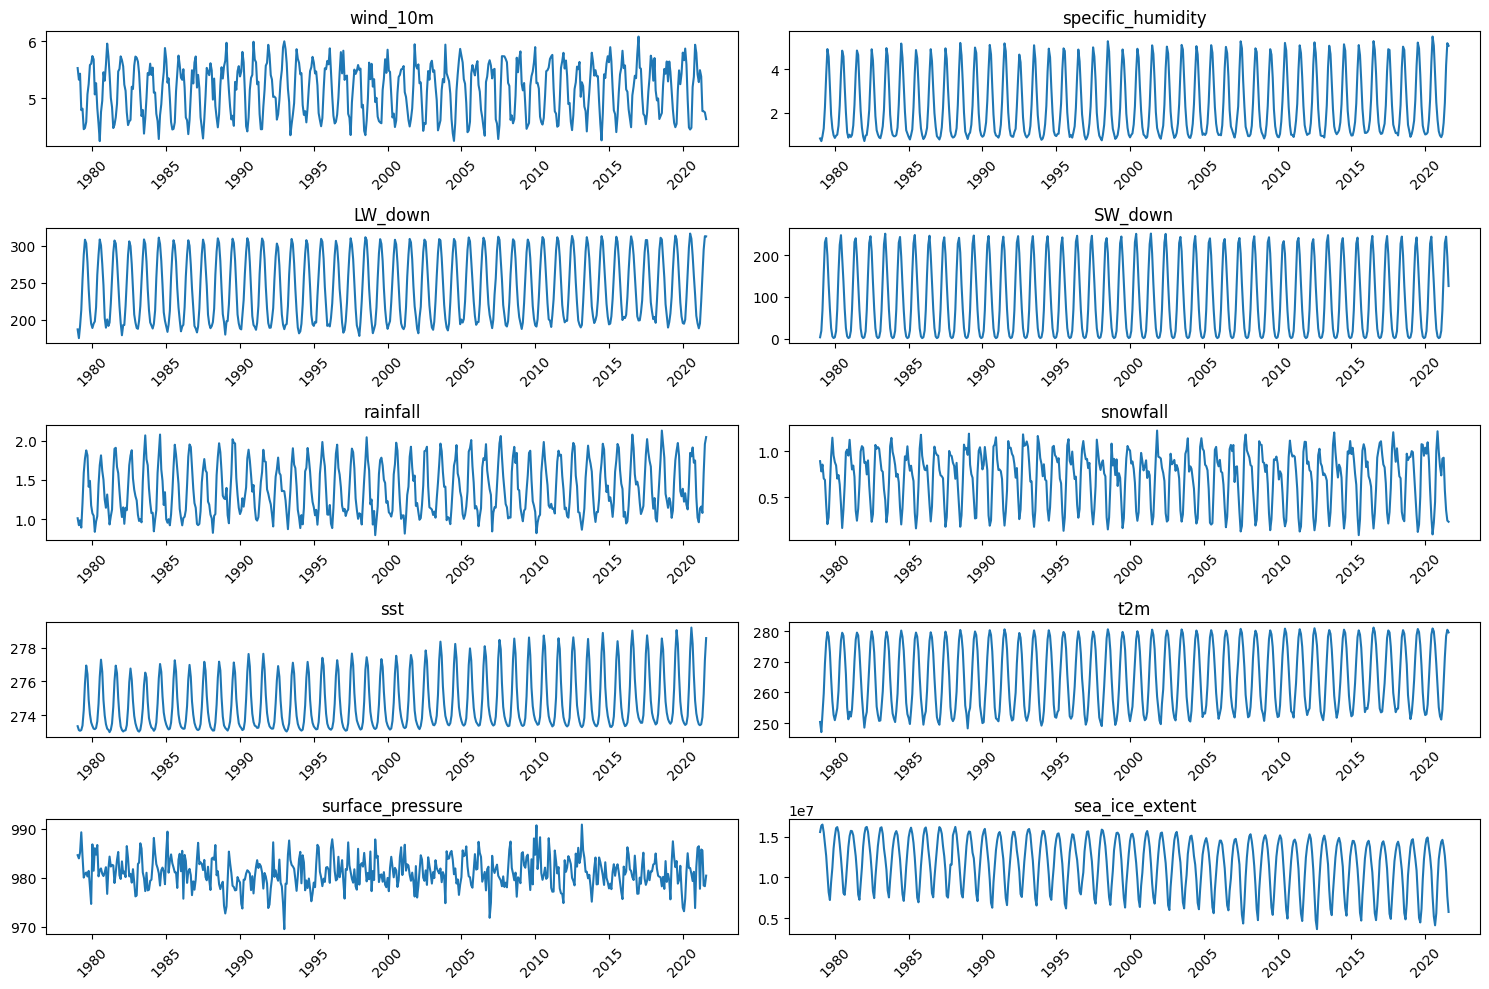

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
from causallearn.search.ConstraintBased.CDNOD import cdnod
from causallearn.utils.cit import kci
import matplotlib.pyplot as plt

# Read the data
df = pd.read_csv('Arctic_Monthly.csv')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Create time index array for CD-NOD
c_indx = np.reshape(np.arange(len(df)), (len(df), 1))

# Select features for causal discovery (excluding Date column)
features = ['wind_10m', 'specific_humidity', 'LW_down', 'SW_down', 'rainfall',
           'snowfall', 'sst', 't2m', 'surface_pressure', 'sea_ice_extent']

# Extract data for CD-NOD
data = df[features].values

# Run CD-NOD
cg = cdnod(data=data,
           c_indx=c_indx,
           alpha=0.05,
           indep_test=kci,
           verbose=True,
           stable=True,
           uc_rule=0,
           uc_priority=-1)

# Plot causal graph
print("\nCausal Graph for Arctic Climate Variables:")
cg.draw_pydot_graph()

# Print summary statistics
print("\nSummary Statistics:")
print(df[features].describe())

# Plot time series for each variable
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(5, 2, i)
    plt.plot(df['Date'], df[feature])
    plt.title(feature)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
!pip install tigramite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.6/309.6 kB 4.8 MB/s eta 0:00:00


In [ ]:
# Import required packages
import pandas as pd
import numpy as np
from tigramite import data_processing as pp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.cmiknn import CMIknn

# Read the Arctic data
df = pd.read_csv('Arctic_Monthly.csv')

# Define variables to analyze
features = ['wind_10m', 'specific_humidity', 'LW_down', 'SW_down', 'rainfall',
           'snowfall', 'sst', 't2m', 'surface_pressure', 'sea_ice_extent']

# Convert data to array format required by PCMCI+
data = df[features].values
dataframe = pp.DataFrame(data,
                        var_names=features)

# Initialize PCMCI+ with CMIknn (k-nearest neighbors conditional mutual information)
cmi = CMIknn(significance='shuffle_test',  # Use shuffle test for significance
             knn=0.2,                      # Fraction of points used for knn
             shuffle_neighbors=5,          # Number of nearest neighbors for shuffling
             transform='ranks',            # Transform to ranks for robustness
             workers=-1)                   # Use all CPU cores

pcmci = PCMCI(dataframe=dataframe,
              cond_ind_test=cmi,
              verbosity=1)

# Run PCMCI+ with lag up to 3 months
results = pcmci.run_pcmciplus(tau_min=0,  # Minimum time lag
                             tau_max=3,    # Maximum time lag
                             pc_alpha=0.05) # Significance level

# Print significant causal links
pcmci.print_significant_links(p_matrix=results['p_matrix'],
                            val_matrix=results['val_matrix'],
                            alpha_level=0.05)

# Print detailed causal links
print("\nDetailed causal relationships:")
for i, var1 in enumerate(features):
    for j, var2 in enumerate(features):
        for tau in range(4):  # 0 to 3 lags
            if results['p_matrix'][i, j, tau] < 0.05:
                print(f"{var2} -{tau}-> {var1} | p-value = {results['p_matrix'][i, j, tau]:.4f}")

# Print summary statistics
n_links = (results['p_matrix'] < 0.05).sum()
print(f"\nTotal number of significant causal links: {n_links}")


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = cmi_knn
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable wind_10m has 3 link(s):
        (SW_down -1): max_pval = 0.00000, |min_val| =  0.183
        (rainfall -3): max_pval = 0.01200, |min_val| =  0.019
        (rainfall -2): max_pval = 0.01600, |min_val| =  0.008

    Variable specific_humidity has 4 link(s):
        (SW_down -1): max_pval = 0.00000, |min_val| =  0.086
        (sea_ice_extent -1): max_pval = 0.03800, |min_val| =  0.016
        (t2m -1): max_pval = 0.00800, |min_val| =  0.008
        (specific_humidity -1): max_pval = 0.01200, |min_val| =  0.008

    Variable LW_down has 2 link(s):
        (SW_down -1): max_pval = 0.00000, |min_val| =  0.217
        (t2m -1): max_pval = 0.04200, |min_val| =  0.011

    Variable SW_down has 1 link(s):
        (wind_10m -3): max_pval = 0.04400, |min_v

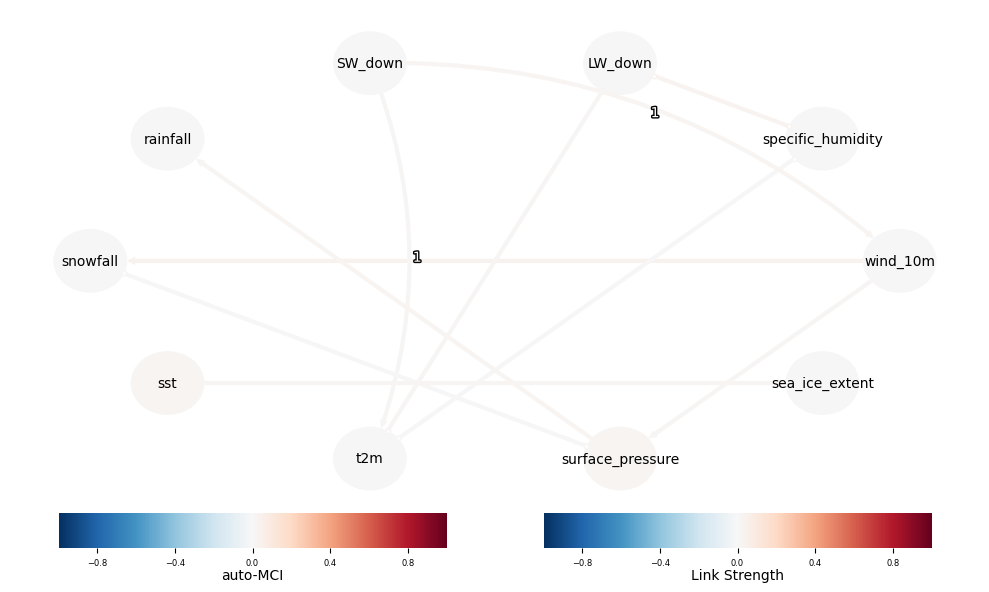

In [ ]:
import numpy as np
from tigramite.plotting import plot_graph
import matplotlib.pyplot as plt

var_names = ['wind_10m', 'specific_humidity', 'LW_down', 'SW_down', 'rainfall',
             'snowfall', 'sst', 't2m', 'surface_pressure', 'sea_ice_extent']

N = len(var_names)
graph = np.zeros((N, N, 2), dtype='bool')
val_matrix = np.zeros((N, N, 2))
link_width = np.zeros((N, N, 2))

name_to_idx = {name: i for i, name in enumerate(var_names)}

# Undirected contemporaneous links
undirected_links = [
    ('specific_humidity', 'LW_down', 0.026),
    ('specific_humidity', 't2m', 0.007),
    ('LW_down', 't2m', 0.012),
    ('snowfall', 'surface_pressure', 0.002)
]

# Directed contemporaneous links
directed_contemp_links = [
    ('surface_pressure', 'rainfall', 0.022),
    ('wind_10m', 'snowfall', 0.034),
    ('wind_10m', 'surface_pressure', 0.013),
    ('sst', 'sea_ice_extent', 0.016)
]

# Lagged links
lagged_links = [
    ('SW_down', 'wind_10m', 0.023),
    ('sst', 'sst', 0.021),
    ('SW_down', 't2m', 0.010),
    ('surface_pressure', 'surface_pressure', 0.023)
]

# Fill undirected contemporaneous links
for i, j, val in undirected_links:
    idx_i, idx_j = name_to_idx[i], name_to_idx[j]
    graph[idx_i, idx_j, 0] = graph[idx_j, idx_i, 0] = True
    val_matrix[idx_i, idx_j, 0] = val_matrix[idx_j, idx_i, 0] = val
    link_width[idx_i, idx_j, 0] = link_width[idx_j, idx_i, 0] = 2.0

# Fill directed contemporaneous links
for i, j, val in directed_contemp_links:
    idx_i, idx_j = name_to_idx[i], name_to_idx[j]
    graph[idx_i, idx_j, 0] = True
    val_matrix[idx_i, idx_j, 0] = val_matrix[idx_j, idx_i, 0] = val
    link_width[idx_i, idx_j, 0] = link_width[idx_j, idx_i, 0] = 2.0

# Fill lagged links
for i, j, val in lagged_links:
    idx_i, idx_j = name_to_idx[i], name_to_idx[j]
    graph[idx_i, idx_j, 1] = True
    val_matrix[idx_i, idx_j, 1] = val
    link_width[idx_i, idx_j, 1] = 2.0

plot_graph(
    graph=graph,
    val_matrix=val_matrix,
    var_names=var_names,
    link_width=link_width,
    figsize=(10, 6),
    node_size=0.3,
    link_colorbar_label='Link Strength',
    arrow_linewidth=3.0
)

plt.tight_layout()
plt.show()